In [ ]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# --- Step 1: Download IMDB dataset (2000 samples: 1000 pos, 1000 neg) ---
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"

if not os.path.exists(dataset_path):
    import requests
    print("Downloading IMDB dataset...")
    r = requests.get(url, stream=True)
    with open(dataset_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Extract only once
if not os.path.exists("aclImdb"):
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall()

# --- Step 2: Collect 1000 pos + 1000 neg ---
base = "aclImdb/train"

pos_files = os.listdir(f"{base}/pos")[:1000]
neg_files = os.listdir(f"{base}/neg")[:1000]

documents = []

# Load positive reviews
for fname in pos_files:
    with open(f"{base}/pos/{fname}", "r", encoding="utf-8") as f:
        documents.append((f.read(), "positive"))

# Load negative reviews
for fname in neg_files:
    with open(f"{base}/neg/{fname}", "r", encoding="utf-8") as f:
        documents.append((f.read(), "negative"))

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=['text', 'label'])
df.head()


,text,label
0,"I agree with the previous comment, the beginni...",negative
1,This movie is as unique as it is overlooked......,positive
2,"You know Jason, you know Freddy, and you know ...",negative
3,Johny To makes here one of his best style exer...,positive
4,Saw this film ran in the wee hours on TCM. Sev...,negative


In [ ]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()


Dataset shape: (2000, 2)

Label distribution:
label
negative    1000
positive    1000
Name: count, dtype: int64


,text,label
0,"I agree with the previous comment, the beginni...",negative
1,This movie is as unique as it is overlooked......,positive
2,"You know Jason, you know Freddy, and you know ...",negative
3,Johny To makes here one of his best style exer...,positive
4,Saw this film ran in the wee hours on TCM. Sev...,negative


In [ ]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])


=== FIRST REVIEW (text sample) ===
I agree with the previous comment, the beginning of the movie is quite good, and get's you wandering about what is to come....... Which is nothing. All open story lines remain open; two characters who at first seemed like they might be of some importance are completely left out of the picture, save  ...

=== TOKENIZED OUTPUT ===
['I', 'agree', 'with', 'the', 'previous', 'comment', ',', 'the', 'beginning', 'of', 'the', 'movie', 'is', 'quite', 'good', ',', 'and', 'get', "'s", 'you', 'wandering', 'about', 'what', 'is', 'to', 'come', '.......', 'Which', 'is', 'nothing']


In [ ]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])


--- NORMALIZATION & STOP WORDS REMOVAL ---
['agree', 'previous', 'comment', ',', 'beginning', 'movie', 'quite', 'good', ',', 'get', "'s", 'wandering', 'come', '.......', 'nothing', '.', 'open', 'story', 'lines', 'remain', 'open', ';', 'two', 'characters', 'first', 'seemed', 'like', 'might', 'importance', 'completely']


In [ ]:
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


In [ ]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['000' '10' '100' '11' '11th' '12' '13' '14' '15' '16' '17' '18' '1912'
 '1930' '1930s' '1933' '1939' '1940' '1941' '1943' '1945' '1948' '1950'
 '1968' '1970' '1976' '1980' '1987' '1989' '1990' '1993' '1994' '1996'
 '1997' '1999' '1st' '20' '2001' '2002' '2003' '2004' '2005' '2006' '2008'
 '24' '25' '30' '35' '3d' '3rd' '40' '45' '50' '50s' '60' '64' '70' '70s'
 '77' '80' '90' '95' '99' 'abandoned' 'abbey' 'abby' 'abc' 'abilities'
 'ability' 'able' 'aboard' 'abroad' 'abrupt' 'absent' 'absolute'
 'absolutely' 'absorbing' 'absurd' 'abu' 'abundance' 'abuse' 'abused'
 'abusive' 'academy' 'accent' 'accents' 'accept' 'accepted' 'accepting'
 'accepts' 'accident' 'accidentally' 'acclaimed' 'accompanied'
 'accomplish' 'according' 'account' 'accurate' 'accurately' 'accused']


In [ ]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
**SPOILERS*** Slow as molasses mummy movie involving this expiation in the Valley of the Kings in Egypt that has to be aborted in order to keep the native population, who are at the time revolting against British rule, from finding out about it.<br /><br />Given the task of getting to this archaeolo ...

Top 10 weighted terms:
tet                  -> 0.4384
numar                -> 0.3945
ra                   -> 0.3752
ha                   -> 0.3663
tomb                 -> 0.2314
quentin              -> 0.2152
capt                 -> 0.1992
storm                -> 0.1701
simira               -> 0.1660
pharaoh              -> 0.1245


In [ ]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 105543
Total elements  : 7500000
Sparsity        : 1.4072%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
      000   10  100   11  11th   12   13   14   15   16
0  0.0681  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
1  0.0000  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2  0.0000  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
3  0.0000  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
4  0.0000  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


In [ ]:
# Step 2: TF-IDF Feature Extraction on IMDB Reviews
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# We assume df from Step 1 exists with columns: ["text", "label"]

# -----------------------------
# 1. Train-Test Split
# -----------------------------
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""

vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


Train size: 1600
Test size : 400


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1600, 5000)
Test TF-IDF shape : (400, 5000)


In [ ]:
# -----------------------------
# 3. Vocabulary Inspection
# -----------------------------
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 50 features:")
print(vocab[:50])



Vocabulary size: 5000

Sample of first 50 features:
['00' '000' '10' '100' '101' '11' '12' '13' '14' '15' '16' '17' '18'
 '1912' '1930' '1930s' '1933' '1939' '1940' '1941' '1943' '1945' '1948'
 '1949' '1950' '1960' '1968' '1970' '1972' '1976' '1980' '1987' '1989'
 '1990' '1993' '1994' '1996' '1997' '1999' '1st' '20' '2000' '2001' '2002'
 '2003' '2004' '2005' '2006' '2008' '24']


In [ ]:
# -----------------------------
# 4. Inspect TF-IDF Weights for a Single Review
# -----------------------------
import numpy as np

doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")



=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
Teresa Pavlinek was a popular member of the Toronto Second City cast. She has done numerous guest spots and commercials up here in Canada. Finally someone has the sense to create a show for her. The supporting case seems quite good too. I have now watched the pilot several times and I still find it  ...

Top 10 weighted terms:
corner               -> 0.3445
canada               -> 0.3271
gas                  -> 0.2917
toronto              -> 0.1759
aware                -> 0.1759
global               -> 0.1723
guest                -> 0.1690
companion            -> 0.1690
spots                -> 0.1662
2005                 -> 0.1662


In [ ]:
# -----------------------------
# 5. Visualizing TF-IDF Matrix Structure
# -----------------------------
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))



=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 111787
Total elements  : 8000000
Sparsity        : 1.3973%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100  101   11   12   13   14   15
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [ ]:
# Baseline Model - Naive Bayes with TF-IDF

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=negative
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=positive, Actual=positive
Review 3: Predicted=negative, Actual=negative
Review 4: Predicted=negative, Actual=negative



=== CONFUSION MATRIX ===
                 Pred_Positive  Pred_Negative
Actual_Positive            185             15
Actual_Negative             14            186


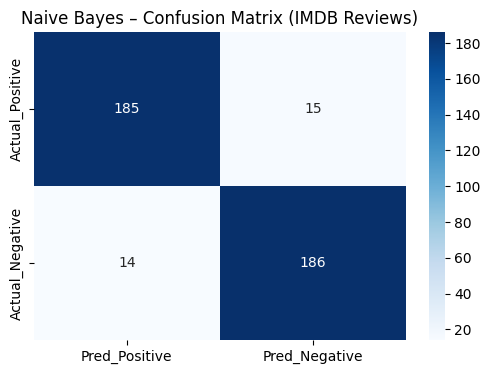


TP=185, FN=15, FP=14, TN=186


In [ ]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["Actual_Positive", "Actual_Negative"],
                     columns=["Pred_Positive", "Pred_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [ ]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.9275
Precision: 0.9296
Recall   : 0.9250
F1-score : 0.9273

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93       200
    positive       0.93      0.93      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.
